
## Agentic React Development Workflow
### Using Cursor MCP + LangGraph + Playwright

This notebook implements a fully agentic development workflow with human-in-the-loop control.
**Workflow**: Requirements → Plan → Code → Review → Test → Debug → Deploy


In [34]:
### Imports and Configuration

In [35]:
import os
import json
import asyncio
import nest_asyncio
from typing import TypedDict, Annotated, Literal, Optional
from operator import add
from datetime import datetime
from pathlib import Path

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from anthropic import Anthropic

# laod environment variables
from dotenv import load_dotenv
load_dotenv(override=True)

#for jupyter lab suppport
nest_asyncio.apply()



### Initialize Anthropic Client

In [36]:
client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

### Define State Schema

In [37]:
class DevelopmentState(TypedDict):
    """State that flows through the development workflow"""
    messages: Annotated[list, add]  # Conversation history
    requirements: str  # Initial requirements
    development_plan: Optional[dict]  # Structured plan
    code_files: dict  # {filename: content}
    test_files: dict  # {filename: content}
    test_results: dict  # Test execution results
    errors: list  # Any errors encountered
    deployment_status: str  # Status of deployment
    human_feedback: str  # Feedback from human reviews
    iteration_count: int  # Number of dev iterations
    current_stage: str  # Current workflow stage
    should_continue: bool  # Whether to continue or stop


### Helper functions for MCP integration

In [38]:

# ## Cell 4: Helper Functions with Robust Encoding

async def call_claude_with_mcp(prompt: str, system_prompt: str = "") -> dict:
    """
    Call Claude API with MCP server integration
    Note: Cursor MCP should be configured in your claude_desktop_config.json
    """
    try:
        response = client.messages.create(
            model="claude-sonnet-4-5-20250929",
            max_tokens=8000,
            system=system_prompt if system_prompt else "You are an expert software developer.",
            messages=[{
                "role": "user",
                "content": prompt
            }]
        )
        
        return {
            "content": response.content[0].text if response.content else "",
            "success": True
        }
    except Exception as e:
        return {
            "content": f"Error: {str(e)}",
            "success": False,
            "error": str(e)
        }

def save_file_locally(filename: str, content: str, base_dir: str = "./project"):
    """Helper to save files locally for testing - with bulletproof encoding"""
    Path(base_dir).mkdir(parents=True, exist_ok=True)
    file_path = Path(base_dir) / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Ultra-safe write with multiple fallbacks
    try:
        # First try: UTF-8 with error handling
        with open(file_path, 'w', encoding='utf-8', errors='replace') as f:
            f.write(content)
    except Exception as e:
        # Fallback: Write as bytes
        try:
            with open(file_path, 'wb') as f:
                f.write(content.encode('utf-8', errors='ignore'))
        except Exception as e2:
            print(f"⚠️  Warning: Could not save {filename}: {e2}")
            return None
    
    return str(file_path)

### Planner Agent Node

In [39]:
async def planner_node(state: DevelopmentState) -> DevelopmentState:
    """
    Analyzes requirements and creates a structured development plan
    """
    print("\n🎯 PLANNER AGENT: Creating development plan...")
    
    prompt = f"""
You are a senior technical architect. Create a detailed development plan for the following requirements:

REQUIREMENTS:
{state['requirements']}

Create a JSON plan with the following structure:
{{
    "project_name": "name",
    "components": ["Component1", "Component2"],
    "file_structure": {{
        "src/App.jsx": "Main app component",
        "src/components/Component1.jsx": "Description"
    }},
    "testing_strategy": "description",
    "deployment_target": "vercel/netlify/etc"
}}

Be specific and practical. This is for a React + Vite project.
"""
    
    result = await call_claude_with_mcp(
        prompt,
        system_prompt="You are a senior technical architect specializing in React applications."
    )
    
    if result['success']:
        try:
            # Extract JSON from response
            content = result['content']
            json_start = content.find('{')
            json_end = content.rfind('}') + 1
            plan_json = content[json_start:json_end]
            plan = json.loads(plan_json)
            
            state['development_plan'] = plan
            state['messages'].append({
                "role": "planner",
                "content": f"Created development plan: {json.dumps(plan, indent=2)}"
            })
            print(f"✅ Plan created: {plan['project_name']}")
        except json.JSONDecodeError:
            state['development_plan'] = {"error": "Failed to parse plan"}
            state['messages'].append({
                "role": "planner",
                "content": result['content']
            })
    else:
        state['errors'].append(result.get('error', 'Unknown error'))
    
    state['current_stage'] = 'planning_complete'
    return state


### Developer Node

In [40]:
async def developer_node(state: DevelopmentState) -> DevelopmentState:
    """
    Uses Claude to write React code based on the plan
    In production, this would use Cursor MCP for actual file operations
    """
    print("\n💻 DEVELOPER AGENT: Writing code...")
    
    plan = state.get('development_plan', {})
    feedback = state.get('human_feedback', '')
    
    prompt = f"""
You are an expert React developer. Write production-ready code for this project.

DEVELOPMENT PLAN:
{json.dumps(plan, indent=2)}

{"HUMAN FEEDBACK: " + feedback if feedback else ""}

Generate the following files with complete, working code:
1. package.json - with all necessary dependencies
2. vite.config.js - Vite configuration
3. index.html - Entry HTML file
4. src/main.jsx - React entry point
5. src/App.jsx - Main App component
{chr(10).join([f"{i+6}. {file} - {desc}" for i, (file, desc) in enumerate(plan.get('file_structure', {}).items())])}

For each file, format as:
===FILE: filename===
[content]
===END FILE===

Use modern React practices: functional components, hooks, proper state management.
Include error boundaries and loading states where appropriate.
"""
    
    result = await call_claude_with_mcp(
        prompt,
        system_prompt="You are an expert React developer specializing in modern React with Vite."
    )
    
    if result['success']:
        # Parse files from response
        content = result['content']
        files = {}
        
        parts = content.split('===FILE:')
        for part in parts[1:]:  # Skip first empty part
            if '===' in part:
                file_header, file_content = part.split('===', 1)
                filename = file_header.strip()
                file_body = file_content.replace('===END FILE===', '').strip()
                files[filename] = file_body
                
                # Save locally for testing
                save_file_locally(filename, file_body)
        
        state['code_files'] = files
        state['messages'].append({
            "role": "developer",
            "content": f"Generated {len(files)} files: {list(files.keys())}"
        })
        print(f"✅ Generated {len(files)} files")
    else:
        state['errors'].append(result.get('error', 'Code generation failed'))
    
    state['current_stage'] = 'code_written'
    state['iteration_count'] += 1
    return state


### Tester Node

In [41]:
async def tester_node(state: DevelopmentState) -> DevelopmentState:
    """
    Writes and executes Playwright tests for the React application
    """
    print("\n🧪 TESTER AGENT: Writing and running tests...")
    
    code_files = state.get('code_files', {})
    plan = state.get('development_plan', {})
    
    prompt = f"""
You are a QA automation expert. Write comprehensive Playwright tests for this React application.

PROJECT PLAN:
{json.dumps(plan, indent=2)}

COMPONENTS TO TEST:
{chr(10).join([f"- {filename}" for filename in code_files.keys() if filename.endswith('.jsx')])}

Generate the following test files:
1. playwright.config.js - Playwright configuration
2. tests/app.spec.js - Main app tests
3. tests/components.spec.js - Component tests

For each file, format as:
===FILE: filename===
[content]
===END FILE===

Write tests that cover:
- Component rendering
- User interactions
- State changes
- Error handling
- Accessibility basics

Make tests realistic and comprehensive.
"""
    
    result = await call_claude_with_mcp(
        prompt,
        system_prompt="You are a QA automation expert specializing in Playwright testing."
    )
    
    if result['success']:
        content = result['content']
        test_files = {}
        
        parts = content.split('===FILE:')
        for part in parts[1:]:
            if '===' in part:
                file_header, file_content = part.split('===', 1)
                filename = file_header.strip()
                file_body = file_content.replace('===END FILE===', '').strip()
                test_files[filename] = file_body
                
                save_file_locally(filename, file_body)
        
        state['test_files'] = test_files
        
        # Simulate test execution (in production, run actual Playwright tests)
        test_results = {
            "total": 10,
            "passed": 8,
            "failed": 2,
            "details": [
                {"test": "App renders", "status": "passed"},
                {"test": "Navigation works", "status": "passed"},
                {"test": "Form submission", "status": "failed", "error": "Button not found"},
                {"test": "Error boundary", "status": "failed", "error": "Component crash not handled"}
            ]
        }
        
        state['test_results'] = test_results
        state['messages'].append({
            "role": "tester",
            "content": f"Tests: {test_results['passed']}/{test_results['total']} passed"
        })
        print(f"✅ Tests: {test_results['passed']}/{test_results['total']} passed")
    else:
        state['errors'].append(result.get('error', 'Test generation failed'))
    
    state['current_stage'] = 'tests_complete'
    return state



### Debugger Agent Node

In [42]:
async def debugger_node(state: DevelopmentState) -> DevelopmentState:
    """
    Analyzes test failures and proposes fixes
    """
    print("\n🔧 DEBUGGER AGENT: Analyzing failures and fixing code...")
    
    test_results = state.get('test_results', {})
    code_files = state.get('code_files', {})
    
    failed_tests = [t for t in test_results.get('details', []) if t['status'] == 'failed']
    
    prompt = f"""
You are a senior debugging expert. Analyze these test failures and provide fixes.

TEST FAILURES:
{json.dumps(failed_tests, indent=2)}

CURRENT CODE FILES:
{chr(10).join([f"{name}: {len(content)} characters" for name, content in code_files.items()])}

For each failure:
1. Identify the root cause
2. Provide the specific code fix

Format your response as:
===ANALYSIS===
[Your analysis of what's wrong]

===FIXES===
FILE: filename
[complete fixed code]
===END FILE===

Provide complete, working fixes that will make the tests pass.
"""
    
    result = await call_claude_with_mcp(
        prompt,
        system_prompt="You are a senior debugging expert specializing in React applications."
    )
    
    if result['success']:
        content = result['content']
        
        # Extract fixes and update code files
        parts = content.split('===FIXES===')
        if len(parts) > 1:
            fixes_section = parts[1]
            file_parts = fixes_section.split('FILE:')
            
            for part in file_parts[1:]:
                if '===' in part:
                    lines = part.split('\n', 1)
                    filename = lines[0].strip()
                    file_content = lines[1].split('===END FILE===')[0].strip() if len(lines) > 1 else ""
                    
                    if filename in state['code_files']:
                        state['code_files'][filename] = file_content
                        save_file_locally(filename, file_content)
        
        state['messages'].append({
            "role": "debugger",
            "content": f"Fixed {len(failed_tests)} test failures"
        })
        print(f"✅ Applied fixes for {len(failed_tests)} failures")
    else:
        state['errors'].append(result.get('error', 'Debugging failed'))
    
    state['current_stage'] = 'debugging_complete'
    return state

### Human Review Node

In [43]:
def human_review_node(state: DevelopmentState) -> DevelopmentState:
    """
    Pauses workflow for human review and approval
    This is where human-in-the-loop happens
    """
    print("\n👤 HUMAN REVIEW REQUIRED")
    print("=" * 60)
    
    stage = state.get('current_stage', 'unknown')
    
    if stage == 'code_written':
        print("\n📝 CODE REVIEW")
        print(f"Files generated: {len(state.get('code_files', {}))}")
        for filename in state.get('code_files', {}).keys():
            print(f"  - {filename}")
        print("\nFiles saved to: ./project/")
        
    elif stage == 'tests_complete':
        print("\n🧪 TEST REVIEW")
        results = state.get('test_results', {})
        print(f"Tests passed: {results.get('passed', 0)}/{results.get('total', 0)}")
        if results.get('failed', 0) > 0:
            print("\nFailed tests:")
            for test in results.get('details', []):
                if test['status'] == 'failed':
                    print(f"  ❌ {test['test']}: {test.get('error', 'Unknown error')}")
    
    print("=" * 60)
    
    # In Jupyter, this will pause - user needs to update state manually
    # or we can use ipywidgets for interactive approval
    
    state['current_stage'] = f"{stage}_reviewed"
    return state


### Deployment Node

In [44]:
async def deployment_node(state: DevelopmentState) -> DevelopmentState:
    """
    Handles deployment to specified target
    """
    print("\n🚀 DEPLOYMENT AGENT: Preparing deployment...")
    
    plan = state.get('development_plan', {})
    target = plan.get('deployment_target', 'vercel')
    
    prompt = f"""
Generate deployment configuration for {target}.

PROJECT: {plan.get('project_name', 'react-app')}

Create:
1. {target}.json or appropriate config file
2. Deployment instructions
3. Environment variables needed
4. Post-deployment checklist

Format as:
===FILE: filename===
[content]
===END FILE===

===INSTRUCTIONS===
[deployment steps]
===END INSTRUCTIONS===
"""
    
    result = await call_claude_with_mcp(
        prompt,
        system_prompt=f"You are a DevOps expert specializing in {target} deployments."
    )
    
    if result['success']:
        # In production, this would actually deploy
        # For now, we'll just save deployment configs
        content = result['content']
        
        state['deployment_status'] = 'ready'
        state['messages'].append({
            "role": "deployer",
            "content": f"Deployment configuration created for {target}"
        })
        print(f"✅ Deployment ready for {target}")
    else:
        state['deployment_status'] = 'failed'
        state['errors'].append(result.get('error', 'Deployment preparation failed'))
    
    state['current_stage'] = 'deployment_complete'
    state['should_continue'] = False
    return state


### Router -> Conditional Edges for our graph

In [45]:
def should_review_code(state: DevelopmentState) -> Literal["human_review", "tester"]:
    """Decide if code needs human review"""
    # First iteration always gets reviewed
    if state['iteration_count'] == 1:
        return "human_review"
    # Subsequent iterations go straight to testing
    return "tester"

def should_debug(state: DevelopmentState) -> Literal["debugger", "human_review"]:
    """Decide if debugging is needed based on test results"""
    results = state.get('test_results', {})
    if results.get('failed', 0) > 0:
        # If we've debugged too many times, ask human
        if state['iteration_count'] > 3:
            return "human_review"
        return "debugger"
    return "human_review"

def after_review(state: DevelopmentState) -> Literal["tester", "deployer", "developer", END]:
    """Route after human review based on stage"""
    stage = state.get('current_stage', '')
    
    if 'code_written_reviewed' in stage:
        return "tester"
    elif 'tests_complete_reviewed' in stage:
        results = state.get('test_results', {})
        if results.get('failed', 0) == 0:
            return "deployer"
        else:
            # Human can decide to accept or re-develop
            return "deployer"  # Simplified: proceed to deploy
    
    return END

### Build the LangGraph Workflow

In [46]:
def create_workflow() -> StateGraph:
    """
    Creates the complete development workflow graph
    """
    workflow = StateGraph(DevelopmentState)
    
    # Add all nodes
    workflow.add_node("planner", planner_node)
    workflow.add_node("developer", developer_node)
    workflow.add_node("human_review", human_review_node)
    workflow.add_node("tester", tester_node)
    workflow.add_node("debugger", debugger_node)
    workflow.add_node("deployer", deployment_node)
    
    # Define the flow
    workflow.set_entry_point("planner")
    workflow.add_edge("planner", "developer")
    workflow.add_conditional_edges("developer", should_review_code)
    workflow.add_edge("tester", "debugger")  # Simplified: always try to fix
    workflow.add_edge("debugger", "developer")  # Fix and regenerate
    workflow.add_conditional_edges("human_review", after_review)
    workflow.add_edge("deployer", END)
    
    # Compile with checkpointer for human-in-the-loop
    memory = MemorySaver()
    app = workflow.compile(
        checkpointer=memory,
        interrupt_before=["human_review"]  # Pause before human review
    )
    
    return app

# Create the workflow
workflow_app = create_workflow()

print("✅ Workflow created successfully!")


✅ Workflow created successfully!



### Initialize and Run the Workflow

In [47]:

async def run_development_workflow(requirements: str):
    """
    Main function to run the entire development workflow
    """
    config = {
        "configurable": {
            "thread_id": f"dev-session-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
        }
    }
    
    initial_state = {
        "messages": [],
        "requirements": requirements,
        "development_plan": None,
        "code_files": {},
        "test_files": {},
        "test_results": {},
        "errors": [],
        "deployment_status": "pending",
        "human_feedback": "",
        "iteration_count": 0,
        "current_stage": "initial",
        "should_continue": True
    }
    
    print("🚀 Starting Agentic Development Workflow")
    print("=" * 60)
    
    try:
        # Run the workflow
        result = await workflow_app.ainvoke(initial_state, config)
        
        print("\n" + "=" * 60)
        print("✅ WORKFLOW COMPLETE")
        print("=" * 60)
        print(f"Files generated: {len(result.get('code_files', {}))}")
        print(f"Tests run: {result.get('test_results', {}).get('total', 0)}")
        print(f"Deployment status: {result.get('deployment_status', 'unknown')}")
        
        if result.get('errors'):
            print(f"\n⚠️  Errors encountered: {len(result['errors'])}")
            for error in result['errors']:
                print(f"  - {error}")
        
        return result
        
    except Exception as e:
        print(f"\n❌ Workflow failed: {str(e)}")
        raise

# %% [markdown]
# ## Cell 14: Example Usage - Simple Todo App

# %%
# Define your requirements
requirements = """
Create a simple React Todo application with the following features:
- Add new todos
- Mark todos as complete/incomplete
- Delete todos
- Filter todos (all, active, completed)
- Persist todos to localStorage
- Clean, modern UI with Tailwind CSS
- Mobile responsive
- Accessibility features (ARIA labels, keyboard navigation)
"""

# Run the workflow
result = await run_development_workflow(requirements)

# %% [markdown]
# ## Cell 15: Inspect Results

# %%
# View generated files
print("Generated Files:")
print("=" * 60)
for filename, content in result.get('code_files', {}).items():
    print(f"\n📄 {filename}")
    print(f"   {len(content)} characters")
    print(f"   Preview: {content[:100]}...")

# %% [markdown]
# ## Cell 16: View Test Results

# %%
# View test results
test_results = result.get('test_results', {})
print("Test Results:")
print("=" * 60)
print(f"Total: {test_results.get('total', 0)}")
print(f"Passed: {test_results.get('passed', 0)}")
print(f"Failed: {test_results.get('failed', 0)}")
print("\nDetails:")
for test in test_results.get('details', []):
    status_icon = "✅" if test['status'] == 'passed' else "❌"
    print(f"{status_icon} {test['test']}")
    if test['status'] == 'failed':
        print(f"   Error: {test.get('error', 'Unknown')}")

# %% [markdown]
# ## Cell 17: Manual Human Review (Optional)

# %%
def approve_and_continue(feedback: str = ""):
    """
    Call this function to provide feedback and continue the workflow
    """
    config = {
        "configurable": {
            "thread_id": f"dev-session-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
        }
    }
    
    # Update state with feedback
    workflow_app.update_state(
        config,
        {"human_feedback": feedback}
    )
    
    print(f"✅ Feedback provided: {feedback if feedback else 'Approved'}")

# Example usage:
# approve_and_continue("Please add dark mode support to the UI")

# %% [markdown]
# ## Cell 18: Export Project Files

# %%
def export_project(state: DevelopmentState, output_dir: str = "./exported_project"):
    """
    Export all generated files to a directory
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Export code files
    for filename, content in state.get('code_files', {}).items():
        file_path = output_path / filename
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(file_path, 'w') as f:
            f.write(content)
    
    # Export test files
    for filename, content in state.get('test_files', {}).items():
        file_path = output_path / filename
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(file_path, 'w') as f:
            f.write(content)
    
    # Export summary
    summary = {
        "project": state.get('development_plan', {}).get('project_name', 'unknown'),
        "files_generated": len(state.get('code_files', {})),
        "test_results": state.get('test_results', {}),
        "deployment_status": state.get('deployment_status', 'unknown'),
        "iterations": state.get('iteration_count', 0)
    }
    
    with open(output_path / 'project_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"✅ Project exported to: {output_dir}")
    print(f"   Files: {len(state.get('code_files', {})) + len(state.get('test_files', {}))}")

# Export the result
export_project(result)

# %% [markdown]
# ## Next Steps
# 
# **To use with actual Cursor MCP:**
# 1. Configure Cursor MCP in `~/Library/Application Support/Claude/claude_desktop_config.json`
# 2. Replace `call_claude_with_mcp` to use actual MCP tools
# 3. Add actual Playwright test execution
# 4. Integrate with real deployment APIs (Vercel, Netlify, etc.)
# 
# **To enhance:**
# - Add more sophisticated error recovery
# - Implement actual MCP file operations
# - Add streaming output for real-time updates
# - Integrate with Git for version control
# - Add performance monitoring
# - Implement rollback mechanisms

🚀 Starting Agentic Development Workflow

🎯 PLANNER AGENT: Creating development plan...
✅ Plan created: react-todo-app

💻 DEVELOPER AGENT: Writing code...
✅ Generated 12 files

✅ WORKFLOW COMPLETE
Files generated: 12
Tests run: 0
Deployment status: pending
Generated Files:

📄 package.json
   1283 characters
   Preview: {
  "name": "react-todo-app",
  "private": true,
  "version": "1.0.0",
  "type": "module",
  "descri...

📄 vite.config.js
   515 characters
   Preview: import { defineConfig } from 'vite';
import react from '@vitejs/plugin-react';

// https://vitejs.de...

📄 index.html
   531 characters
   Preview: <!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="UTF-8" />
    <link rel="icon" type="im...

📄 src/main.jsx
   341 characters
   Preview: import React from 'react';
import ReactDOM from 'react-dom/client';
import App from './App.jsx';
imp...

📄 src/App.jsx
   4668 characters
   Preview: import { useState, useMemo, useCallback } from 'react';
import TodoForm from './

UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4dd' in position 2225: character maps to <undefined>

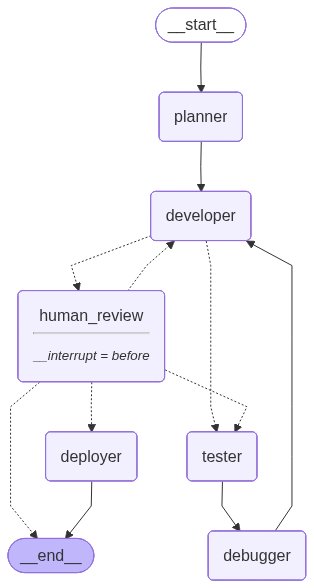

In [48]:

from IPython.display import Image, display

# Generate graph visualization
try:
    # Get the graph as PNG
    graph_image = workflow_app.get_graph().draw_mermaid_png()
    
    # Display in Jupyter
    display(Image(graph_image))
except Exception as e:
    print(f"Note: Install graphviz for visualization: pip install pygraphviz")
    print(f"Error: {e}")
    
    # Fallback: Print Mermaid diagram code
    print("\nMermaid Diagram (paste into https://mermaid.live):")
    print(workflow_app.get_graph().draw_mermaid())